In [1]:
#select geno
import h5py
from Bio import AlignIO
import pickle
from matplotlib import pyplot as plt
import numpy as np
#run annot
from scipy.sparse import lil_matrix




In [2]:
treefile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln.treefile'
alnfile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln'
alnh5 = alnfile+'.h5'

In [3]:
#choose sequence
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array'][:]
print(align_array.shape)
msa = AlignIO.read(alnfile , format = 'fasta')

def clipID(ID):
    return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
IDs = {i:rec.id for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

(35244, 29903)
[('hCoV-19/Wuhan-Hu-1/2019|EPI_ISL_402125', 0), ('hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20', 1), ('hCoV-19/Scotland/EDB410/2020|EPI_ISL_426002|2020-03-30', 2), ('hCoV-19/Scotland/EDB413/2020|EPI_ISL_426004|2020-03-29', 3), ('hCoV-19/Scotland/EDB421/2020|EPI_ISL_426006|2020-03-30', 4), ('hCoV-19/Wuhan/Hu-1/2019|EPI_ISL_402125|2019-12-31', 5), ('hCoV-19/Sichuan/SC-NJ-089/2020|EPI_ISL_451338|2020-02-05', 6), ('hCoV-19/Sichuan/SC-WCH3-259/2020|EPI_ISL_451385|2020-02-03', 7), ('hCoV-19/Sichuan/SC-WCH4-285/2020|EPI_ISL_451387|2020-01-27', 8), ('hCoV-19/Sichuan/SC-WCH4-286/2020|EPI_ISL_451388|2020-02-10', 9)]


In [4]:
seq = 'hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20'
print('seq chosen: ' , seq)
#index all non gap cols
aln_row = align_array[IDindex[seq],:]
nongap_cols = [ i for i,c in enumerate(list(aln_row)) if c != b'-' ]
print(nongap_cols[0:100])
#grab cols from coevmat
#grab cols from aln

seq chosen:  hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [5]:
with open( alnfile+ 'blurmatr3.pkl' , 'rb') as matin:
    coevmat = pickle.loads(matin.read())


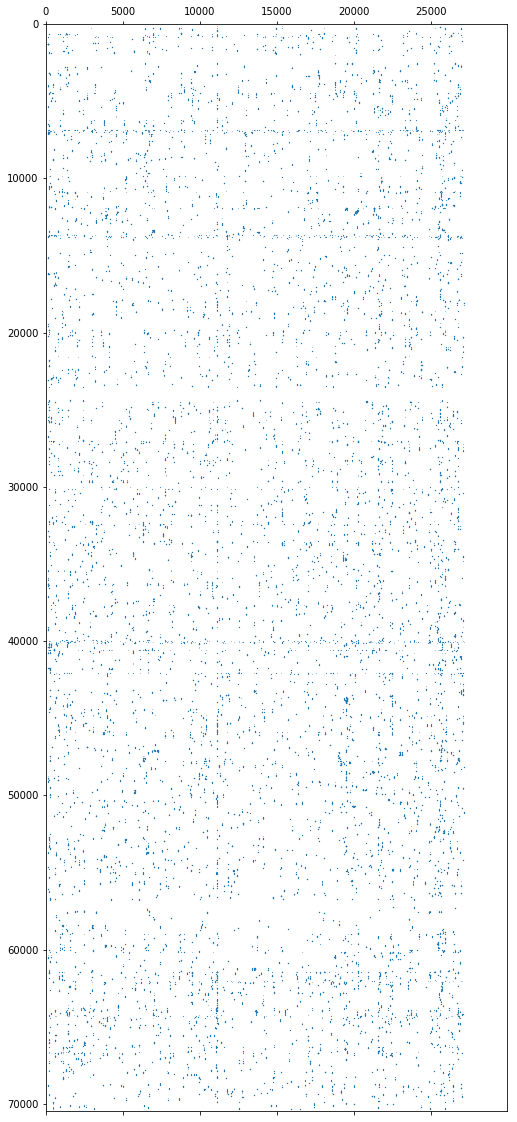

In [6]:
submat_coev = coevmat[: , nongap_cols ]
submat_aln = align_array[:,nongap_cols ]
plt.figure( figsize=(30,20))
plt.spy(submat_coev ,  markersize = .1)


In [7]:
qseq = b''.join(aln_row[nongap_cols])
qfile = 'covid_geno.fasta'
with open(qfile , 'w') as geno_out:
    geno_out.write((b'>testgeno\n'+qseq).decode())
    #print( (b'>testgeno\n'+qseq).decode())


In [8]:
import subprocess
import shlex
import pandas as pd 
#collapse codons
#use tblastn to map to prot

def runblastx( qseq , outannot = 'outannot.txt' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = 'blastx -query '+ qfile + ' -db covid_prots -outfmt' + outfmt + ' -out ' + outannot  
    p = subprocess.run( shlex.split(args) )
    return p , outannot
out = 'outannot.txt'
p,annot = runblastx(qfile  )

annotation = pd.read_csv( out , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]
print(annotation)
print(len(annotation), ' orfs detected')

#recluster codons
#load blast results into df

 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0   testgeno  YP_009724389.1  29903  7096     266  13468       2   
1   testgeno  YP_009724389.1  29903  7096   13462  21552       1   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
7   testgeno  YP_009742610.1  29903  1945    2720   8554       2   
11  testgeno  YP_009724390.1  29903  1273   21596  25381       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
14  testgeno  YP_009742609.1  29903   638     806   2719       2   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
18  testgeno  YP_009742611.1  29903   500    8555  10054       2   
19  testgeno  YP_009725310.1  29903   346   19621  20658 

In [9]:
#select longest nice hit
from Bio import Seq

rows = []
for ID in annotation.sseqid.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.sseqid == ID ]
    rows.append(sub.index[0] ) 
annotation = annotation.loc[rows]
print(len(annotation))
rows = []

for ID in annotation.qstart.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.qstart == ID ]
    rows.append(sub.index[0] )
annotation = annotation.loc[rows]
print(len(annotation))

genes =  {}
prots = {}

for i,r in annotation.iterrows():
    genes[i] = qseq[r.qstart-1:r.qend-1].decode()
    #print(genes[i])
    prots[i] = str(Seq.Seq( genes[i]).translate( ) )


annotation = annotation.sort_values( ['qstart'] )


annotation['prots'] = annotation.index.map(prots)
annotation['genes'] = annotation.index.map(genes)
print(annotation)




36
25
      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0   testgeno  YP_009724389.1  29903  7096     266  13468       2   
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346 

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [10]:
import numpy as np
annotation = annotation[annotation.slen < 2000]
print(annotation)
aln_regions = np.array(list(zip(list(annotation.qstart),list(annotation.qend))))
aln_regions= aln_regions[1:,:]
aln_len = np.array(list( annotation.qend - annotation.qstart))
print(np.sum(aln_len) )
print(len(qseq))

      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298   2065

In [11]:
print(annotation)

      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298   2065

In [12]:
annotation.to_csv('./gisaid/'+seq.replace('/', '_').replace('|','_')+'.csv')


In [13]:
from scipy.sparse  import lil_matrix
#collapse codons

#submat_coev = submat_coev.todense()

lenprots = sum ( [ len(prot) for prot in list(annotation.prots) ])


In [75]:
codonmat = np.zeros( (submat_coev.shape[0] , int(submat_coev.shape[1]/3) +1  ))
count = 0
print(codonmat.shape)
print(submat_coev.shape)


try:
    submat_coev = submat_coev.todense()
except AttributeError:
    print( 'already dense')
    
codon_dict = {}

for i,r in annotation.iterrows():
    for j,codon in enumerate(range(r.qstart-1, r.qend-1 , 3 )):
        
        
        codon_dict[codon] = count
        cols = np.sum( submat_coev[:, codon:codon+2] , axis = 1 )
        codonmat[:,count] = cols.ravel()
        count+=1
        if count%500 == 0:
            print(count/lenprots)


codonthresh = codonmat[codonmat>0] = 1

(70486, 9968)
(70486, 29903)
already dense
0.05250997689561017
0.10501995379122034
0.1575299306868305
0.21003990758244068
0.26254988447805083
0.315059861373661
0.36756983826927114
0.42007981516488135
0.4725897920604915
0.5250997689561017
0.5776097458517119
0.630119722747322
0.6826296996429322
0.7351396765385423
0.7876496534341525
0.8401596303297627
0.8926696072253728
0.945179584120983
0.9976895610165931


In [44]:
codon_dict_rev = dict(zip ( codon_dict.values() , codon_dict.keys( ) ) )

In [45]:
print(list(codon_dict.keys())[0:10])
print(list(codon_dict.values())[0:10])

[805, 808, 811, 814, 817, 820, 823, 826, 829, 832]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


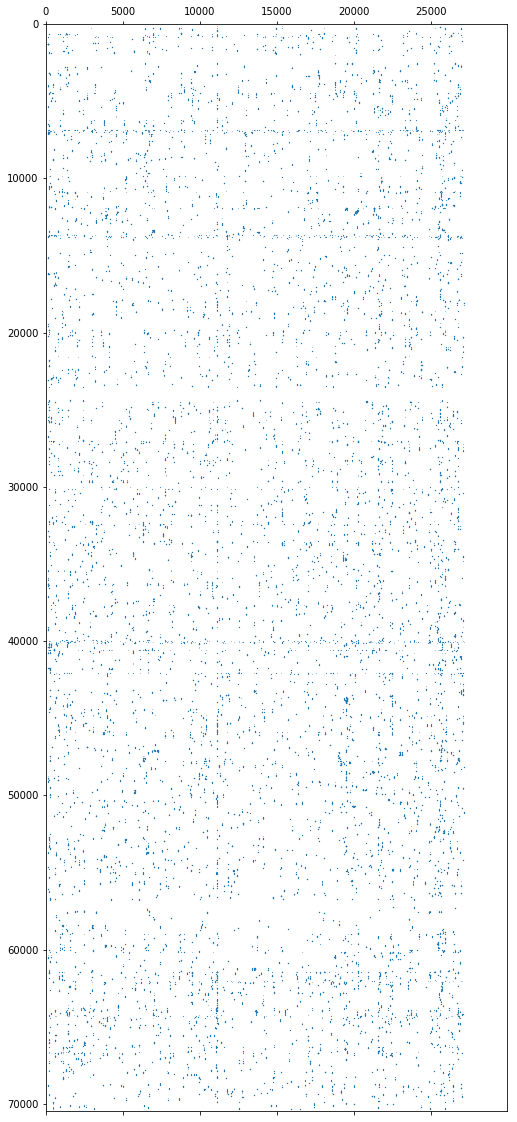

In [46]:
plt.figure( figsize=(30,20))
plt.spy(submat_coev , markersize = .1 )

In [47]:

apb = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=100, verbose=1, compute_labels=True  )

#apb = DBSCAN( eps = .2 , metric='jaccard', metric_params=None, algorithm='auto', leaf_size=25, p=None, n_jobs=-1)
cluster_labelsb_raw = apb.fit_predict(submat_coev.T )
print(cluster_labelsb[1000:1200])




Init 1/3 with method: k-means++
Inertia for init 1/3: 8177.925644
Init 2/3 with method: k-means++
Inertia for init 2/3: 8409.934291
Init 3/3 with method: k-means++
Inertia for init 3/3: 8608.205763
Minibatch iteration 1/30000: mean batch inertia: 25.115408, ewa inertia: 25.115408 
Minibatch iteration 2/30000: mean batch inertia: 18.718056, ewa inertia: 25.072622 
Minibatch iteration 3/30000: mean batch inertia: 10.460981, ewa inertia: 24.974899 
Minibatch iteration 4/30000: mean batch inertia: 23.586663, ewa inertia: 24.965614 
Minibatch iteration 5/30000: mean batch inertia: 28.337526, ewa inertia: 24.988166 
Minibatch iteration 6/30000: mean batch inertia: 7.549180, ewa inertia: 24.871533 
Minibatch iteration 7/30000: mean batch inertia: 7.762949, ewa inertia: 24.757109 
Minibatch iteration 8/30000: mean batch inertia: 6.500148, ewa inertia: 24.635005 
Minibatch iteration 9/30000: mean batch inertia: 24.788555, ewa inertia: 24.636032 
[MiniBatchKMeans] Reassigning 50 cluster centers.

In [232]:
lr,cr = np.unique(cluster_labelsb_raw, return_counts= True)
print(len(lr))
print(cr)
print(np.sum(cr))


53
[   65     1     1     1     1     1     1     2     1     1     1     1
     1     2     3     4     3     3     2     1     1     2     4     1
     3     3     2     1     1     5     2     2    31    41    25    23
    39    35    35    27    28    19    32    24    23     8 29381     1
     1     1     2     2     2]
29903


cluster: 0
cluster size: 118
cluster: 1
cluster size: 15
cluster: 2
cluster size: 12


KeyboardInterrupt: 

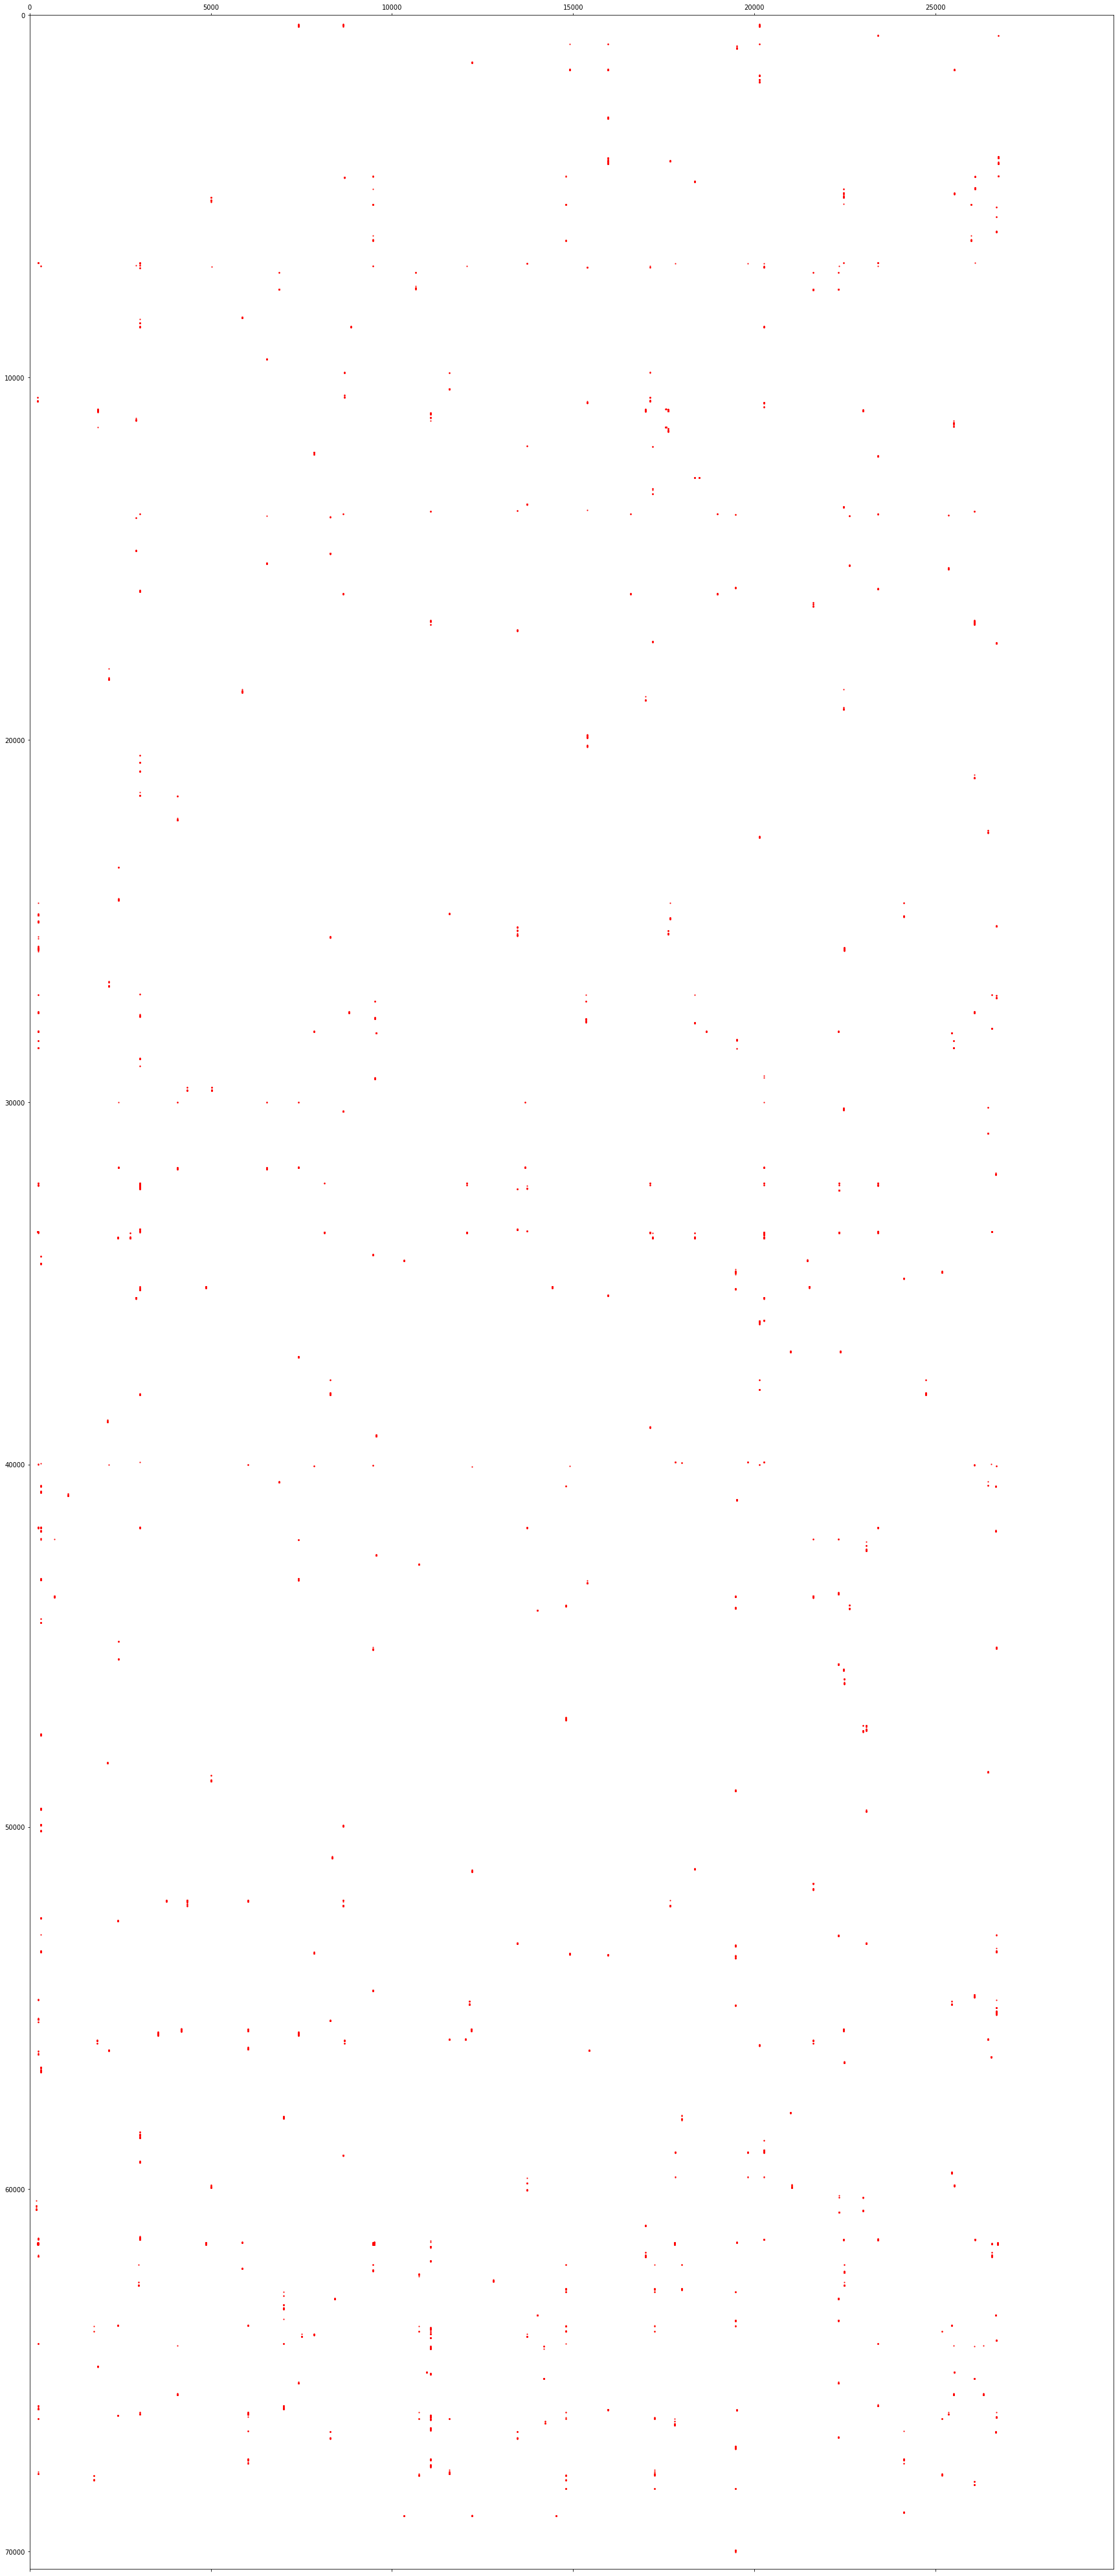

In [48]:
#blurmat = blurmat.todense()
import copy

plt.figure( figsize=(30,200))
for i,label in enumerate(np.unique(cluster_labelsb_raw)):
    if len(cluster_labelsb_raw[ cluster_labelsb_raw==label ] ) < 200 and len(cluster_labelsb_raw[ cluster_labelsb_raw==label ] ) > 6:
        print('cluster:',label)
        print( 'cluster size:' ,len(cluster_labelsb_raw[ cluster_labelsb_raw==label ] ) )
        mask =  copy.deepcopy(submat_coev)
        mask[:,  cluster_labelsb_raw!=label ] = 0
        plt.spy( mask, markersize = 1 , mfc = crange[i]  , mec = crange[i] )

plt.show()


In [ ]:
plt.figure( figsize=(30,200))
plt.spy(codonmat , markersize = 1)

In [ ]:
import pickle
with open( alnfile+'blurmat_codonsr3.pkl' , 'wb') as blurout:
    blurout.write(pickle.dumps(lil_matrix(codonmat) ))



In [ ]:
import pickle

with open( alnfile+'blurmat_codons.pklr3' , 'rb') as blurout:
    codonmat = pickle.loads(blurout.read())

sparsedf = pd.DataFrame.sparse.from_spmatrix(codonmat)

nzx,nzy = codonmat.nonzero()
print(nzx.shape)
print(nzy.shape)
#todo assign clusters to the raw columns
#scatter plot representation of sparse mat
#toggle between
#event mat raw
#blurmat
#codon mat

In [ ]:
datablock = np.vstack([nzx,nzy]).T
print(datablock.shape)

In [49]:
#cluster the informative columns evol events
from sklearn.cluster import MiniBatchKMeans , DBSCAN

apb = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=100, verbose=1, compute_labels=True , random_state= 0   )

#apb = DBSCAN( eps = .2 , metric='jaccard', metric_params=None, algorithm='auto', leaf_size=25, p=None, n_jobs=-1)
cluster_labelsb = apb.fit_predict(codonmat.T )
print(cluster_labelsb[1000:1200])


Init 1/3 with method: k-means++
Inertia for init 1/3: 1740.511225
Init 2/3 with method: k-means++
Inertia for init 2/3: 1620.930589
Init 3/3 with method: k-means++
Inertia for init 3/3: 1752.041530
Minibatch iteration 1/10000: mean batch inertia: 3.899662, ewa inertia: 3.899662 
Minibatch iteration 2/10000: mean batch inertia: 4.198677, ewa inertia: 3.905661 
Minibatch iteration 3/10000: mean batch inertia: 1.239536, ewa inertia: 3.852173 
Minibatch iteration 4/10000: mean batch inertia: 4.337006, ewa inertia: 3.861900 
Minibatch iteration 5/10000: mean batch inertia: 3.389891, ewa inertia: 3.852430 
Minibatch iteration 6/10000: mean batch inertia: 4.199683, ewa inertia: 3.859397 
Minibatch iteration 7/10000: mean batch inertia: 2.374998, ewa inertia: 3.829616 
Minibatch iteration 8/10000: mean batch inertia: 4.336987, ewa inertia: 3.839795 
Minibatch iteration 9/10000: mean batch inertia: 3.312751, ewa inertia: 3.829222 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iter

In [52]:
l,c = np.unique(cluster_labelsb, return_counts= True)
print(len(l))
print(c)
print(np.sum(c))



63
[ 136    1    1    1    1    2    1    1    1    1    1    1    1    2
    1    1    2    1    1    1    2    1    2    2    1    2    1    1
    1    1    1    1    5    2    2    1   40   37   26   43   21   50
   15   34   13   21   21   21   14    7    6    1   31   19   15    1
    1   12 9330    1    2    1    1]
9968


In [53]:
#for each cluster output a list of columns in the original alignment

#0 based indexing!


clusterdf = { label : [ codon_dict_rev[p] for p in list( np.where(cluster_labelsb == label )[0]  ) if p in codon_dict_rev ] for i,label in enumerate(list(l)) if c[i]< 300 and c[i]> 1 } 



clusterdf = pd.DataFrame.from_dict( clusterdf , orient = 'index' , dtype=pd.Int64Dtype() )

print( clusterdf )
print(clusterdf.index)

clusterdf.to_csv( alnfile + 'clusterpositions_columns.csv')

      0      1      2      3      4      5      6      7      8      9    ...  \
0     874    883   1057   1324   1375   1426   1624   1756   2092   2209  ...   
5    3562  24931   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
13   5053  16944   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
16  16692  21366   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
20  18030  23269   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
22  23041  26540   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
23  11533  13569   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
25  11074  14391   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
32   6310  10330  18927  25554  26783   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
33   4474  19116   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
34  12703  12796   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
36   1513   1615   1876   23

In [54]:
#save each cl
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')
crange = [ c.get_hex_l() for c in red.range_to(blue, np.amax(cluster_labelsb)) ]
print(crange)

with open( 'crange.pkl' , 'wb') as crangeout:
    crangeout.write(pickle.dumps(crange))

['#ff0000', '#ff0c00', '#ff1900', '#ff2500', '#ff3100', '#ff3d00', '#ff4a00', '#ff5600', '#ff6200', '#ff6f00', '#ff7b00', '#ff8700', '#ff9300', '#ffa000', '#ffac00', '#ffb800', '#ffc500', '#ffd100', '#ffdd00', '#ffe900', '#fff600', '#fcff00', '#f0ff00', '#e3ff00', '#d7ff00', '#cbff00', '#beff00', '#b2ff00', '#a6ff00', '#9aff00', '#8dff00', '#81ff00', '#75ff00', '#68ff00', '#5cff00', '#50ff00', '#44ff00', '#37ff00', '#2bff00', '#1fff00', '#12ff00', '#06ff00', '#00ff06', '#00ff12', '#00ff1f', '#00ff2b', '#00ff37', '#00ff44', '#00ff50', '#00ff5c', '#00ff68', '#00ff75', '#00ff81', '#00ff8d', '#00ff9a', '#00ffa6', '#00ffb2', '#00ffbe', '#00ffcb', '#00ffd7', '#00ffe3', '#00fff0', '#00fffc', '#00f6ff', '#00e9ff', '#00ddff', '#00d1ff', '#00c5ff', '#00b8ff', '#00acff', '#00a0ff', '#0093ff', '#0087ff', '#007bff', '#006fff', '#0062ff', '#0056ff', '#004aff', '#003dff', '#0031ff', '#0025ff', '#0019ff', '#000cff', '#0000ff']


In [ ]:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[],
    y=[0.75, 0.75],
    text=["Unfilled Rectangle", "Filled Rectangle"],
    mode="text",
))

# Set axes properties
fig.update_xaxes(range=[0, 7], showgrid=False)
fig.update_yaxes(range=[0, 3.5])
fig.add_shape(
        # filled Rectangle
            type="rect",
            x0=3,
            y0=10,
            x1=6,
            y1=20,
            line=dict(
                color="RoyalBlue",
                width=2,
            ),
            fillcolor="LightSkyBlue",
        )
fig.update_shapes(dict(xref='x', yref='y'))

fig.show()





In [28]:
import plotly.express as px

nzdf = pd.DataFrame( data = datablock , columns = ['nzx', 'nzy'] , index = np.arange(nzx.shape[0]) )
nzdf['clusters'] = 0
nzdf['colors'] = '0'
nzdf['size'] = .1

#todo, label the change on each event
for i,l in enumerate(np.unique(cluster_labelsb)):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        labels =  np.where(cluster_labelsb==l)
        
        
        nzdf['clusters'][ nzdf['nzy'].isin( labels ) ] =  l
        nzdf['colors'][ nzdf['nzy'].isin(labels) ] =  crange[l]
        nzdf['size'][ nzdf['nzy'].isin(labels) ] =  1
        
        
        

NameError: name 'datablock' is not defined

In [ ]:
              
print(nzdf)
print(nzdf.clusters.unique())

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=700, algorithm='randomized', n_iter=20, random_state=0 , tol=0.0)
codon_reduce = svd.fit_transform( codonmat.T )


In [ ]:
apb = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=100, verbose=1, compute_labels=True , random_state= 0   )

#apb = DBSCAN( eps = .2 , metric='jaccard', metric_params=None, algorithm='auto', leaf_size=25, p=None, n_jobs=-1)
cluster_labelsb = apb.fit_predict(codon_reduce )


In [ ]:
l,c = np.unique(cluster_labelsb, return_counts= True)
print(len(l))
print(c)
print(np.sum(c))



In [ ]:
clustervec = np.zeros((100,codon_reduce.shape[1]))



cluster: 0
cluster size: 136
cluster: 36
cluster size: 40
cluster: 37
cluster size: 37
cluster: 38
cluster size: 26
cluster: 39
cluster size: 43
cluster: 40
cluster size: 21
cluster: 41
cluster size: 50
cluster: 42
cluster size: 15
cluster: 43
cluster size: 34
cluster: 44
cluster size: 13
cluster: 45
cluster size: 21
cluster: 46
cluster size: 21
cluster: 47
cluster size: 21
cluster: 48
cluster size: 14
cluster: 49
cluster size: 7
cluster: 52
cluster size: 31
cluster: 53
cluster size: 19
cluster: 54
cluster size: 15
cluster: 57
cluster size: 12


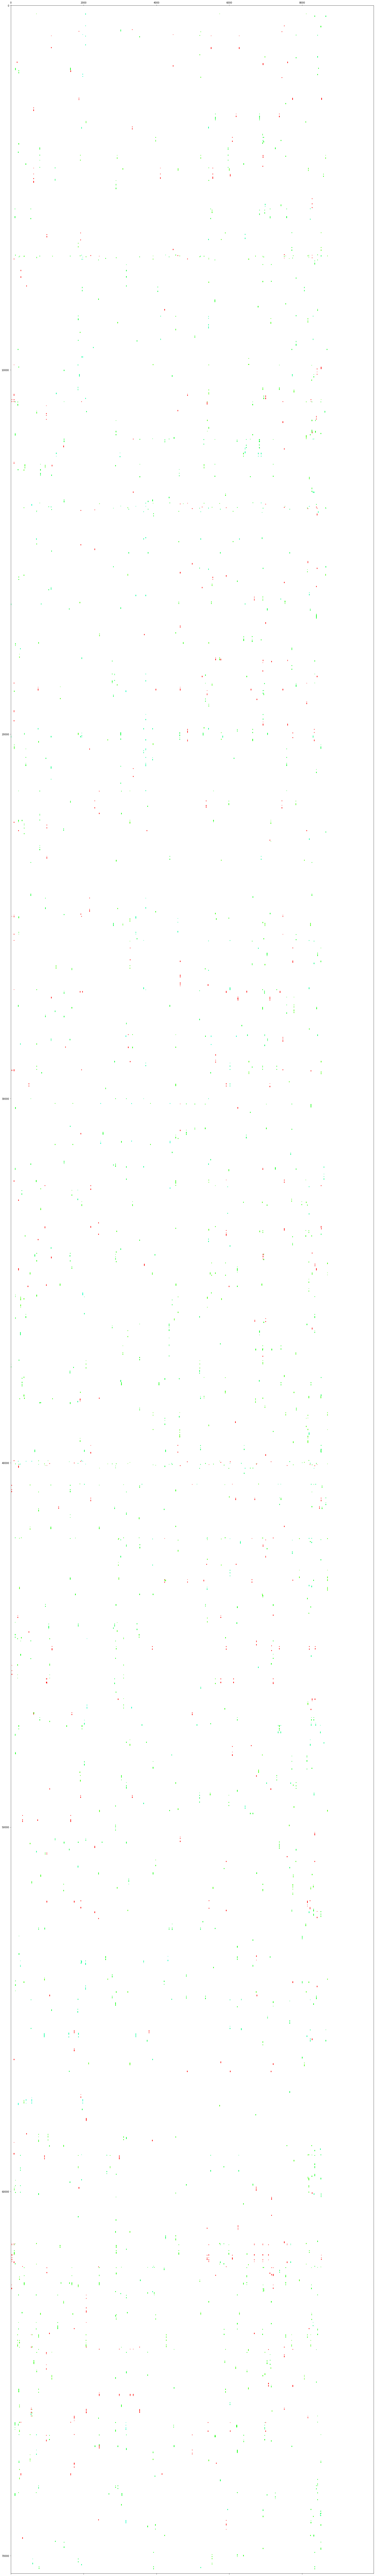

In [55]:
#blurmat = blurmat.todense()
import copy

plt.figure( figsize=(30,200))
for i,l in enumerate(np.unique(cluster_labelsb)):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        print('cluster:',l)
        print( 'cluster size:' ,len(cluster_labelsb[ cluster_labelsb==l ] ) )
        mask =  copy.deepcopy(codonmat)
        mask[:,  cluster_labelsb!=l ] = 0
        plt.spy( mask , markersize = 1 , mfc = crange[i]  , mec = crange[i] )
        
plt.show()


In [62]:
clusters = {}
import json

count = 0
starts = []
stops =[]
for seq in annotation.prots:
    starts.append( count )
    stops.append( count+len(seq) )
    count += len(seq)

annotation['start'] =  starts
annotation['stop'] = stops
print(annotation)

for l in np.unique(cluster_labelsb):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        #index of positions
        cluster_postions = np.where( cluster_labelsb==l )
        
        print(cluster_postions)
        
        for i,r in annotation.iterrows():
            for p in list(cluster_postions[0]):
                
                if r.start < p and r.stop > p:
                    
                    if i not in clusters:
                        clusters[i] = {}
                        
                    if l not in clusters[i]:
                        clusters[i][l] = []
                    
                    clusters[i][l].append(p-(r.start-1))

print(clusters)
annotation['clusters']= annotation.index.map( clusters )

#annotation['clusters'] = annotation.clusters.map( lambda x : json.dumps( x ) )
print(annotation)

annotation.to_csv( alnfile + 'testgeno_wclusters.csv')

with open( alnfile + 'annothack.pkl' , 'wb') as annotout:
    annotout.write(pickle.dumps(annotation))


      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298   2065